In [1]:
# Для работы в колабе раскоменьте эти строки
!git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
%cd DeepGenerativeModels/

%load_ext autoreload
%autoreload 2

Cloning into 'DeepGenerativeModels'...
remote: Enumerating objects: 667, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 667 (delta 90), reused 166 (delta 57), pack-reused 447
Receiving objects: 100% (667/667), 181.32 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (270/270), done.
/content/DeepGenerativeModels


# Этап 1. Загрузка данных
В данном задании вам предстоит работать с уже знакомым датасетом с лицами и генерировать новые лица с заданными аттрибутами

In [2]:
!pip install munch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [12]:
#download_url = 'https://drive.google.com/uc?id=18iuZMt37xcsXPuQfBzepW90JP95HkkRY'

In [4]:
def denormalize_image(image):
    return (image + 1) / 2

In [5]:
import gdown, os
root_dir = '/content/DeepGenerativeModels/data/celeba'
if not os.path.isdir(root_dir):
    os.makedirs(root_dir)

gdown.download("https://drive.google.com/uc?id=1JzOrzDS3bMbFArIy2bRXzoPGD4hrGdVh", 
               './data/celeba/list_attr_celeba.txt', 
               quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1JzOrzDS3bMbFArIy2bRXzoPGD4hrGdVh
To: /content/DeepGenerativeModels/data/celeba/list_attr_celeba.txt
100%|██████████| 26.5M/26.5M [00:00<00:00, 27.8MB/s]


'./data/celeba/list_attr_celeba.txt'

In [11]:
import sys; 
sys.path.append('../../utils/')
sys.path.append('/content/DeepGenerativeModels/utils/')
from datasets.celeba import CelebADataset
import torch
import torch.nn.functional as F
#from lpips_pytorch import LPIPS
from torchvision import transforms
from munch import Munch
import gc
from tqdm.auto import trange


## Setup
# Number of gpus available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Munch()

args.num_domains = 2  #??? # Задайте число доменов

# Spatial size of training images, images are resized to this size.
args.img_size = 32
args.batch_size = 8

# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])
# Load the dataset from file and apply transformations
dataset = CelebADataset(transform=transform)

# args.num_domains = 2*len(dataset.header)
#args.num_domains = len(dataset.header)

# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False


# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(dataset,
                                                batch_size=args.batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

## Визуализация датасетов

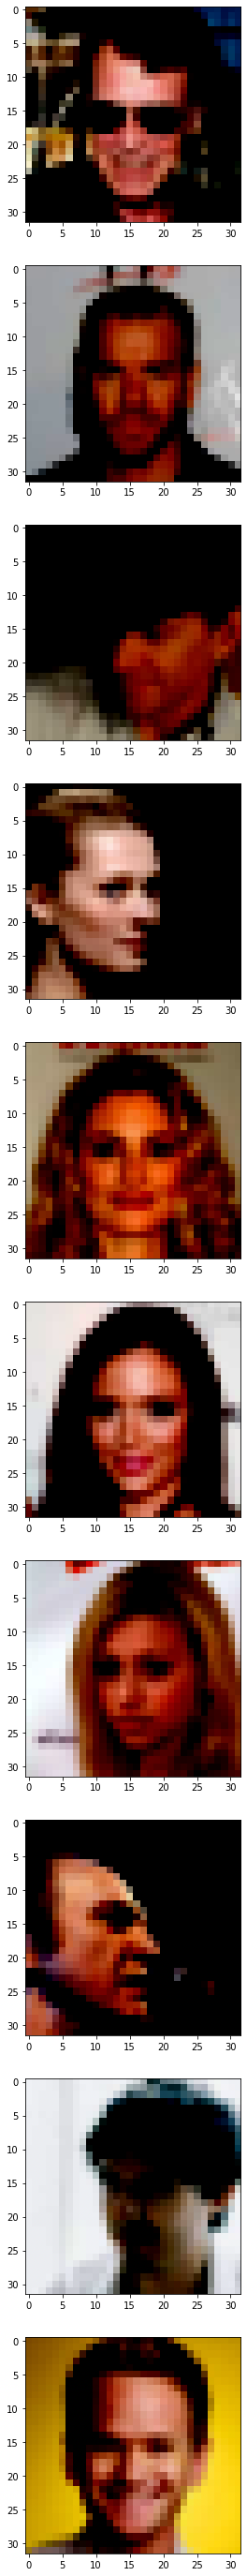

In [14]:
import matplotlib.pyplot as plt
import numpy as np

images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    # attributes dict for a given image. Contains 40 attributes
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(images_cnt,1,i+1)
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))

# Этап 2. Обучение модели
В рамках данного задания предлагается реализовать и обучить StarGAN для генережки лиц с заданными аттрибутами
![](https://github.com/HSE-LAMBDA/DeepGenerativeModels/blob/spring-2023/homework/second/assets/stargan.png?raw=1)

Вам на выбор предлагается реализовать [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**) или [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

In [39]:
# nets = Munch()
# nets.generator = ???
# nets.mapping_network = ???
# nets.style_encoder = ???
# nets.discriminator = ???

In [15]:
import copy
import math

from munch import Munch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

#from core.wing import FAN


class ResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, actv=nn.LeakyReLU(0.2),
                 normalize=False, downsample=False):
        super().__init__()
        self.actv = actv
        self.normalize = normalize
        self.downsample = downsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out)

    def _build_weights(self, dim_in, dim_out):
        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
            self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.learned_sc:
            x = self.conv1x1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.actv(x)
        x = self.conv1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        if self.normalize:
            x = self.norm2(x)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        x = self._shortcut(x) + self._residual(x)
        return x / math.sqrt(2)  # unit variance


class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features*2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta


class AdainResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, style_dim=16,
                 actv=nn.LeakyReLU(0.2), upsample=False):
        super().__init__()
        #self.w_hpf = w_hpf
        self.actv = actv
        self.upsample = upsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out, style_dim)

    def _build_weights(self, dim_in, dim_out, style_dim=16):
        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        self.norm1 = AdaIN(style_dim, dim_in)
        self.norm2 = AdaIN(style_dim, dim_out)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        if self.learned_sc:
            x = self.conv1x1(x)
        return x

    def _residual(self, x, s):
        x = self.norm1(x, s)
        x = self.actv(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv1(x)
        x = self.norm2(x, s)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x, s):
        x = self._shortcut(x) + self._residual(x, s)
        return x / math.sqrt(2)  # unit variance

In [17]:
class Generator(nn.Module):
    def __init__(self, img_size=32, style_dim=64, max_conv_dim=128):
        super().__init__()
        dim_in = 2**11 // img_size
        self.img_size = img_size
        self.from_rgb = nn.Conv2d(3, dim_in, 3, 1, 1)
        self.encode = nn.ModuleList()
        self.decode = nn.ModuleList()
        self.to_rgb = nn.Sequential(
            nn.InstanceNorm2d(dim_in, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, 3, 1, 1, 0))

        # down/up-sampling blocks
        repeat_num = 1 #int(np.log2(img_size)) - 4
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            self.encode.append(
                ResBlk(dim_in, dim_out, normalize=True, downsample=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_in, style_dim,
                               upsample=True))  # stack-like
            dim_in = dim_out

        # bottleneck blocks
        for _ in range(2):
            self.encode.append(
                ResBlk(dim_out, dim_out, normalize=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_out, style_dim))

    def forward(self, x, s, masks=None):
        x = self.from_rgb(x)
        #cache = {}
        for block in self.encode:
            x = block(x)
        for block in self.decode:
            x = block(x, s)
        return self.to_rgb(x)

In [18]:
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, style_dim=64, num_domains=2):
        super().__init__()
        layers = []
        layers += [nn.Linear(latent_dim, 512)]
        layers += [nn.ReLU()]
        for _ in range(3):
            layers += [nn.Linear(512, 512)]
            layers += [nn.ReLU()]
        self.shared = nn.Sequential(*layers)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Sequential(nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, style_dim))]

    def forward(self, z, y):
        h = self.shared(z)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim)
        return s

In [19]:
class StyleEncoder(nn.Module):
    def __init__(self, img_size=32, style_dim=64, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**11 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = 3                 #int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [ResBlk(dim_out, dim_out)]           

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        self.shared = nn.Sequential(*blocks)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Linear(dim_out, style_dim)]

    def forward(self, x, y):
        h = self.shared(x)
        h = h.view(h.size(0), -1)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim)
        return s

In [20]:
class Discriminator(nn.Module):
    def __init__(self, img_size=32, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**11 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = 3  #int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [ResBlk(dim_out, dim_out)]     

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, num_domains, 1, 1, 0)]
        self.main = nn.Sequential(*blocks)

    def forward(self, x, y):
        out = self.main(x)
        out = out.view(out.size(0), -1)  # (batch, num_domains)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        out = out[idx, y]  # (batch)
        return out

In [21]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [22]:
args.latent_dim = 16
args.style_dim = 64
args.f_lr = 1e-6
args.lr = 1e-4
args.beta1 = 0.0
args.beta2 = 0.99
args.weight_decay = 1e-4
args.lambda_sty = 1
args.lambda_ds = 1
args.lambda_cyc = 1
args.lambda_reg = 1
args.ds_iter = 100000
args.total_iters = 100000

In [23]:
def build_model(args):
    generator = nn.DataParallel(Generator(args.img_size, args.style_dim))
    mapping_network = nn.DataParallel(MappingNetwork(args.latent_dim, args.style_dim, args.num_domains))
    style_encoder = nn.DataParallel(StyleEncoder(args.img_size, args.style_dim, args.num_domains))
    discriminator = nn.DataParallel(Discriminator(args.img_size, args.num_domains))
    generator_ema = copy.deepcopy(generator)
    mapping_network_ema = copy.deepcopy(mapping_network)
    style_encoder_ema = copy.deepcopy(style_encoder)

    nets = Munch(generator=generator,
                 mapping_network=mapping_network,
                 style_encoder=style_encoder,
                 discriminator=discriminator)
    nets_ema = Munch(generator=generator_ema,
                     mapping_network=mapping_network_ema,
                     style_encoder=style_encoder_ema)

    return nets, nets_ema

In [24]:
nets, nets_ema = build_model(args)

In [27]:
import gc

nets.generator.load_state_dict(torch.load('/content/drive/MyDrive/StarGan/generator_ep52000.pth',
                            map_location=device))
nets.mapping_network.load_state_dict(torch.load('/content/drive/MyDrive/StarGan/mapping_network_ep52000.pth',
                            map_location=device))
nets.style_encoder.load_state_dict(torch.load('/content/drive/MyDrive/StarGan/style_encoder_ep52000.pth',
                            map_location=device))
nets.discriminator.load_state_dict(torch.load('/content/drive/MyDrive/StarGan/discriminator_ep52000.pth',
                            map_location=device))

nets_ema.generator.load_state_dict(torch.load('/content/drive/MyDrive/StarGan/ema_generator_ep52000.pth',
                            map_location=device))
nets_ema.mapping_network.load_state_dict(torch.load('/content/drive/MyDrive/StarGan/ema_mapping_network_ep52000.pth',
                            map_location=device))
nets_ema.style_encoder.load_state_dict(torch.load('/content/drive/MyDrive/StarGan/ema_style_encoder_ep52000.pth',
                            map_location=device))

gc.collect()

69

In [26]:
import time
optims = Munch()
for net in nets.keys():
    optims[net] = torch.optim.Adam(
                    params=nets[net].parameters(),
                    lr=args.f_lr if net == 'mapping_network' else args.lr,
                    betas=[args.beta1, args.beta2],
                    weight_decay=args.weight_decay)

In [20]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from tqdm.auto import trange
test_iters = 100
losses = []
initial_lambda_ds = args.lambda_ds
start_time = time.time()
for i in trange(100000):
    # fetch images and labels
    x_real, target = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))
    batch_size = x_real.shape[0]
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # целевой домен
    #y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # ваш домен
    y_org = (torch.tensor([target['attributes'][i, 20] for i in range(len(target['attributes']))]) + 1) / 2
    z_trg = torch.randn(x_real.size(0), args.latent_dim)
    z_trg2 = torch.randn(x_real.size(0), args.latent_dim)

    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    z_trg, z_trg2 = [x.to(device).long() for x in [z_trg, z_trg2]]

    # train the discriminator
    d_loss1, d_losses_latent1 = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg.to(torch.float32))
    reset_grad(optims)
    d_loss1.backward()
    optims.discriminator.step()

    d_loss2, d_losses_ref2 = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref.to(torch.float32))
    reset_grad(optims)
    d_loss2.backward()
    optims.discriminator.step()

    # train the generator
    g_loss1, g_losses_latent1 = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg.to(torch.float32), z_trg2.to(torch.float32)])
    reset_grad(optims)
    g_loss1.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()

    g_loss2, g_losses_ref2 = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref.to(torch.float32), x_ref2.to(torch.float32)])
    reset_grad(optims)
    g_loss2.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    if i % 1000 == 0:

        for model in nets_ema:
          torch.save(nets_ema[model].state_dict(),
                    "/content/drive/MyDrive/StarGan/ema_" + model + "_ep%d.pth" % i)
        for model in nets:
          torch.save(nets[model].state_dict(),
                    "/content/drive/MyDrive/StarGan/" + model + "_ep%d.pth" % i)

    losses.append((round(d_loss1.item(), 3),
                    round(g_loss1.item(), 3),
                    round(g_loss2.item(), 3)))

    print(i, losses[-1])    

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

  0%|          | 0/100000 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
40110 (1.409, 0.96, 0.783)
40111 (1.45, 0.758, 0.729)
40112 (1.489, 0.636, 0.712)
40113 (1.271, 0.864, 0.831)
40114 (1.408, 0.64, 0.692)
40115 (1.373, 0.743, 0.715)
40116 (1.339, 0.756, 0.826)
40117 (1.452, 0.694, 0.641)
40118 (1.4, 0.737, 0.723)
40119 (1.442, 0.74, 0.775)
40120 (1.334, 0.843, 0.847)
40121 (1.393, 0.791, 0.722)
40122 (1.398, 0.802, 0.883)
40123 (1.568, 0.709, 0.698)
40124 (1.373, 0.775, 0.738)
40125 (1.377, 0.766, 0.778)
40126 (1.511, 0.79, 0.795)
40127 (1.412, 0.768, 0.784)
40128 (1.498, 0.737, 0.66)
40129 (1.477, 0.681, 0.653)
40130 (1.421, 0.787, 0.741)
40131 (1.38, 0.798, 0.776)
40132 (1.437, 0.819, 0.762)
40133 (1.365, 0.812, 0.827)
40134 (1.255, 1.038, 0.966)
40135 (1.452, 0.759, 0.74)
40136 (1.344, 0.955, 0.874)
40137 (1.366, 0.72, 0.714)
40138 (1.424, 0.773, 0.876)
40139 (1.356, 0.84, 0.637)
40140 (1.338, 0.825, 0.749)
40141 (1.203, 1.126, 0.944)
40142 (1.51, 0.681, 0.764)
40143 (1.261, 0.92, 0

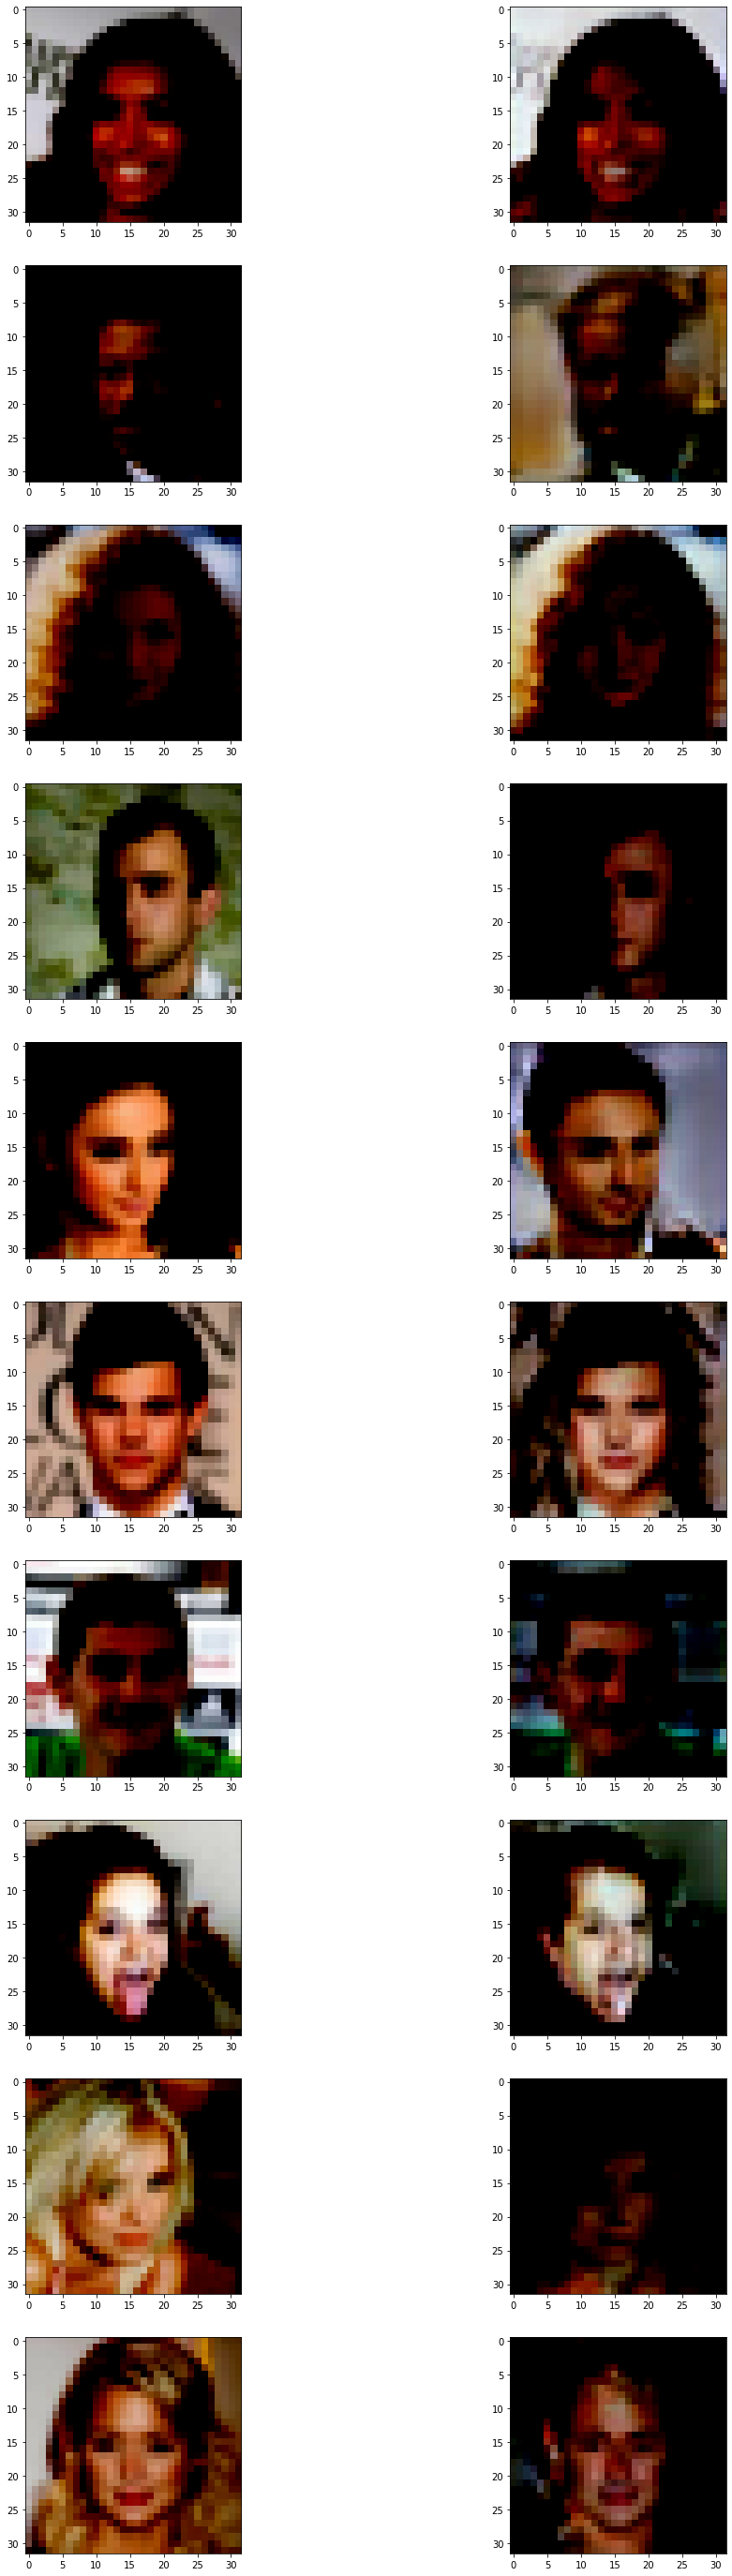

In [29]:
images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    x_ref2, _ = dataset[np.random.choice(range(len(dataset)), 1)[0]]
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=1)) # целевой домен
    # attributes dict for a given image. Contains 40 attributes
    s_trg = nets.style_encoder(x_ref2.unsqueeze(0), y_trg)
    x_fake = nets.generator(img, s_trg)
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(images_cnt,2,2*i+1)
    #img = (img + 1) / 2
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))
    plt.subplot(images_cnt,2,2*i+2)
    x_fake_denorm = x_fake[0, :, : ,:]
    #x_fake_denorm = (x_fake[0, :, : ,:] + 1) / 2
    plt.imshow(x_fake_denorm.detach().cpu().numpy().transpose(1,2,0))

In [30]:
device

device(type='cuda')

In [31]:
def compute_d_loss(nets, args, x_real, y_org, y_trg, z_trg=None, x_ref=None):
    assert (z_trg is None) != (x_ref is None)
    # with real images
    x_real.requires_grad_()
    out = nets.discriminator(x_real, y_org)
    loss_real = adv_loss(out, 1)
    loss_reg = r1_reg(out, x_real)

    # with fake images
    with torch.no_grad():
        if z_trg is not None:
            s_trg = nets.mapping_network(z_trg, y_trg)
        else:  # x_ref is not None
            s_trg = nets.style_encoder(x_ref, y_trg)

        x_fake = nets.generator(x_real, s_trg)
    out = nets.discriminator(x_fake, y_trg)
    loss_fake = adv_loss(out, 0)

    loss = loss_real + loss_fake + args.lambda_reg * loss_reg
    return loss, Munch(real=loss_real.item(),
                       fake=loss_fake.item(),
                       reg=loss_reg.item())

In [32]:
def compute_g_loss(nets, args, x_real, y_org, y_trg, z_trgs=None, x_refs=None):
    assert (z_trgs is None) != (x_refs is None)
    if z_trgs is not None:
        z_trg, z_trg2 = z_trgs
    if x_refs is not None:
        x_ref, x_ref2 = x_refs

    # adversarial loss
    if z_trgs is not None:
        s_trg = nets.mapping_network(z_trg, y_trg)
    else:
        s_trg = nets.style_encoder(x_ref, y_trg)

    x_fake = nets.generator(x_real, s_trg)
    out = nets.discriminator(x_fake, y_trg)
    loss_adv = adv_loss(out, 1)

    # style reconstruction loss
    s_pred = nets.style_encoder(x_fake, y_trg)
    loss_sty = torch.mean(torch.abs(s_pred - s_trg))

    # diversity sensitive loss
    if z_trgs is not None:
        s_trg2 = nets.mapping_network(z_trg2, y_trg)
    else:
        s_trg2 = nets.style_encoder(x_ref2, y_trg)
    x_fake2 = nets.generator(x_real, s_trg2)
    x_fake2 = x_fake2.detach()
    loss_ds = torch.mean(torch.abs(x_fake - x_fake2))

    # cycle-consistency loss
    #masks = nets.fan.get_heatmap(x_fake) if args.w_hpf > 0 else None
    s_org = nets.style_encoder(x_real, y_org)
    x_rec = nets.generator(x_fake, s_org)
    loss_cyc = torch.mean(torch.abs(x_rec - x_real))

    loss = loss_adv + args.lambda_sty * loss_sty \
        - args.lambda_ds * loss_ds + args.lambda_cyc * loss_cyc
    return loss, Munch(adv=loss_adv.item(),
                       sty=loss_sty.item(),
                       ds=loss_ds.item(),
                       cyc=loss_cyc.item())

In [33]:
def reset_grad(optims):
    for optim in optims.values():
        optim.zero_grad()

def moving_average(model, model_test, beta=0.999):
    for param, param_test in zip(model.parameters(), model_test.parameters()):
        param_test.data = torch.lerp(param.data, param_test.data, beta)


def adv_loss(logits, target):
    assert target in [1, 0]
    targets = torch.full_like(logits, fill_value=target)
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss


def r1_reg(d_out, x_in):
    # zero-centered gradient penalty for real images
    batch_size = x_in.size(0)
    grad_dout = torch.autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = 0.5 * grad_dout2.view(batch_size, -1).sum(1).mean(0)
    return reg

# Evaluation

In [34]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-luwj725m
  Running command git clone --filter=blob:none --quiet https://github.com/S-aiueo32/lpips-pytorch.git /tmp/pip-req-build-luwj725m
  Resolved https://github.com/S-aiueo32/lpips-pytorch.git to commit 016e0ae19ceff83450590738948941a7eb9b95b7
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for lpips-pytorch: filename=lpips_pytorch-latest-py3-none-any.whl size=4978 sha256=b89a8fb65d202ded023f28b76453c1624f37b02a7c7b1fc3322456a0c3b16e34
  Stored in directory: /tmp/pip-ephem-wheel-cache-ovgkeg3e/wheels/87/4a/82/33dbec8a13aa8126fdb0b083756d0cbfadd9773c52e8a660fb
Failed to build lpips-pytorch
  Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a w

In [35]:
from lpips_pytorch import LPIPS
lpips = LPIPS()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

In [59]:
from tqdm.auto import trange
test_iters = 100
values = []
for i in trange(test_iters):
    # fetch images and labels
    x_real, target = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))
    batch_size = x_real.shape[0]
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # целевой домен
    #y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # ваш домен
    y_org = (torch.tensor([target['attributes'][i, 20] for i in range(len(target['attributes']))]) + 1) / 2
    
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    s_trg = nets.style_encoder(x_ref, y_trg)
    x_fake = nets.generator(x_real, s_trg)

    values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())

assert(np.mean(values) < 1.3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
np.mean(values)

0.4032896952331066

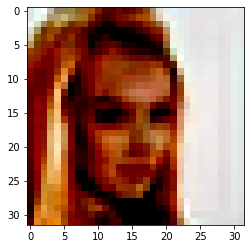

In [38]:
with torch.no_grad():
    z_trg = torch.randn((args.batch_size, args.latent_dim)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
#     s_trg = nets.style_encoder(x_ref2, y_trg)
    x_fake = nets.generator(x_real, s_trg)
plt.imshow(x_fake[1].permute(1,2,0).detach().cpu().numpy())

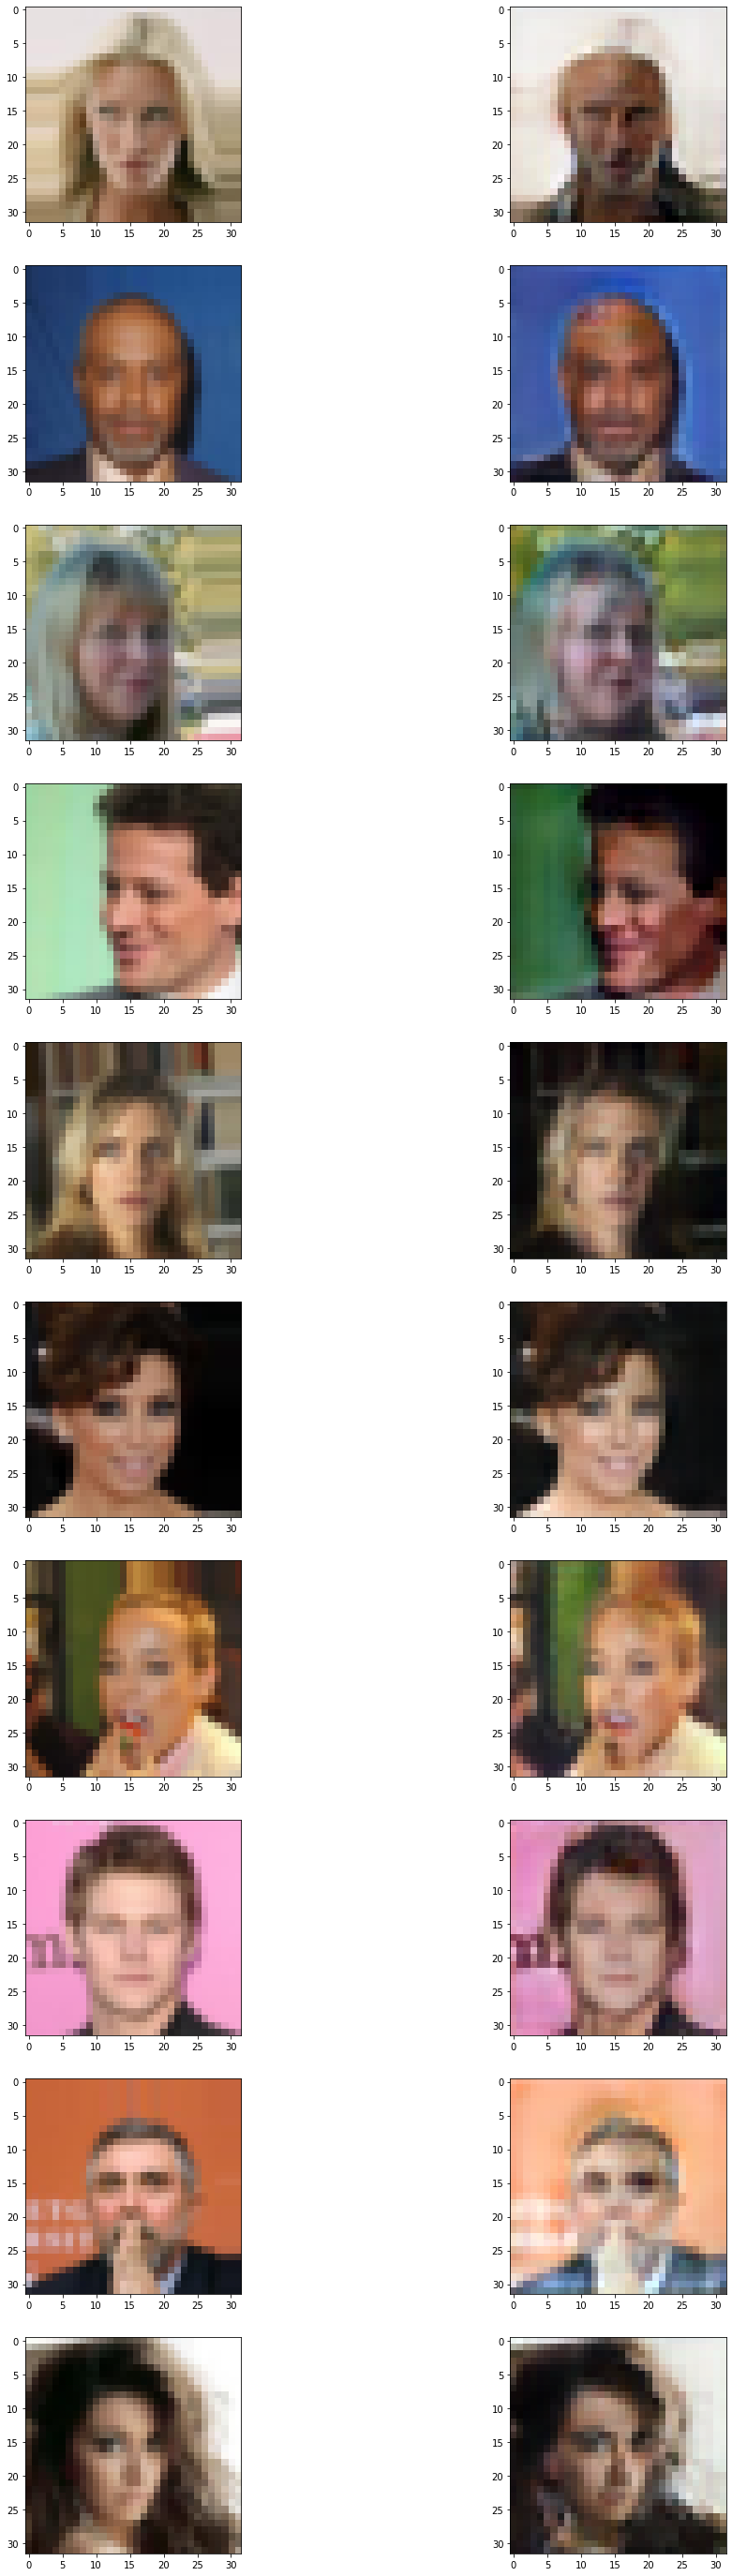

In [41]:
images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    x_ref2, _ = dataset[np.random.choice(range(len(dataset)), 1)[0]]
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=1)) # целевой домен
    # attributes dict for a given image. Contains 40 attributes
    s_trg = nets.style_encoder(x_ref2.unsqueeze(0), y_trg)
    x_fake = nets.generator(img, s_trg)
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(images_cnt,2,2*i+1)
    img = (img + 1) / 2                                           # denormalising
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))
    plt.subplot(images_cnt,2,2*i+2)
    #x_fake_denorm = x_fake[0, :, : ,:]
    x_fake_denorm = (x_fake[0, :, : ,:] + 1) / 2                  # denormalising 
    plt.imshow(x_fake_denorm.detach().cpu().numpy().transpose(1,2,0))

# Этап 3(\*). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **2 балла**
* Текстовое ревью решения и предложения возможных улучшений - **1 балл**

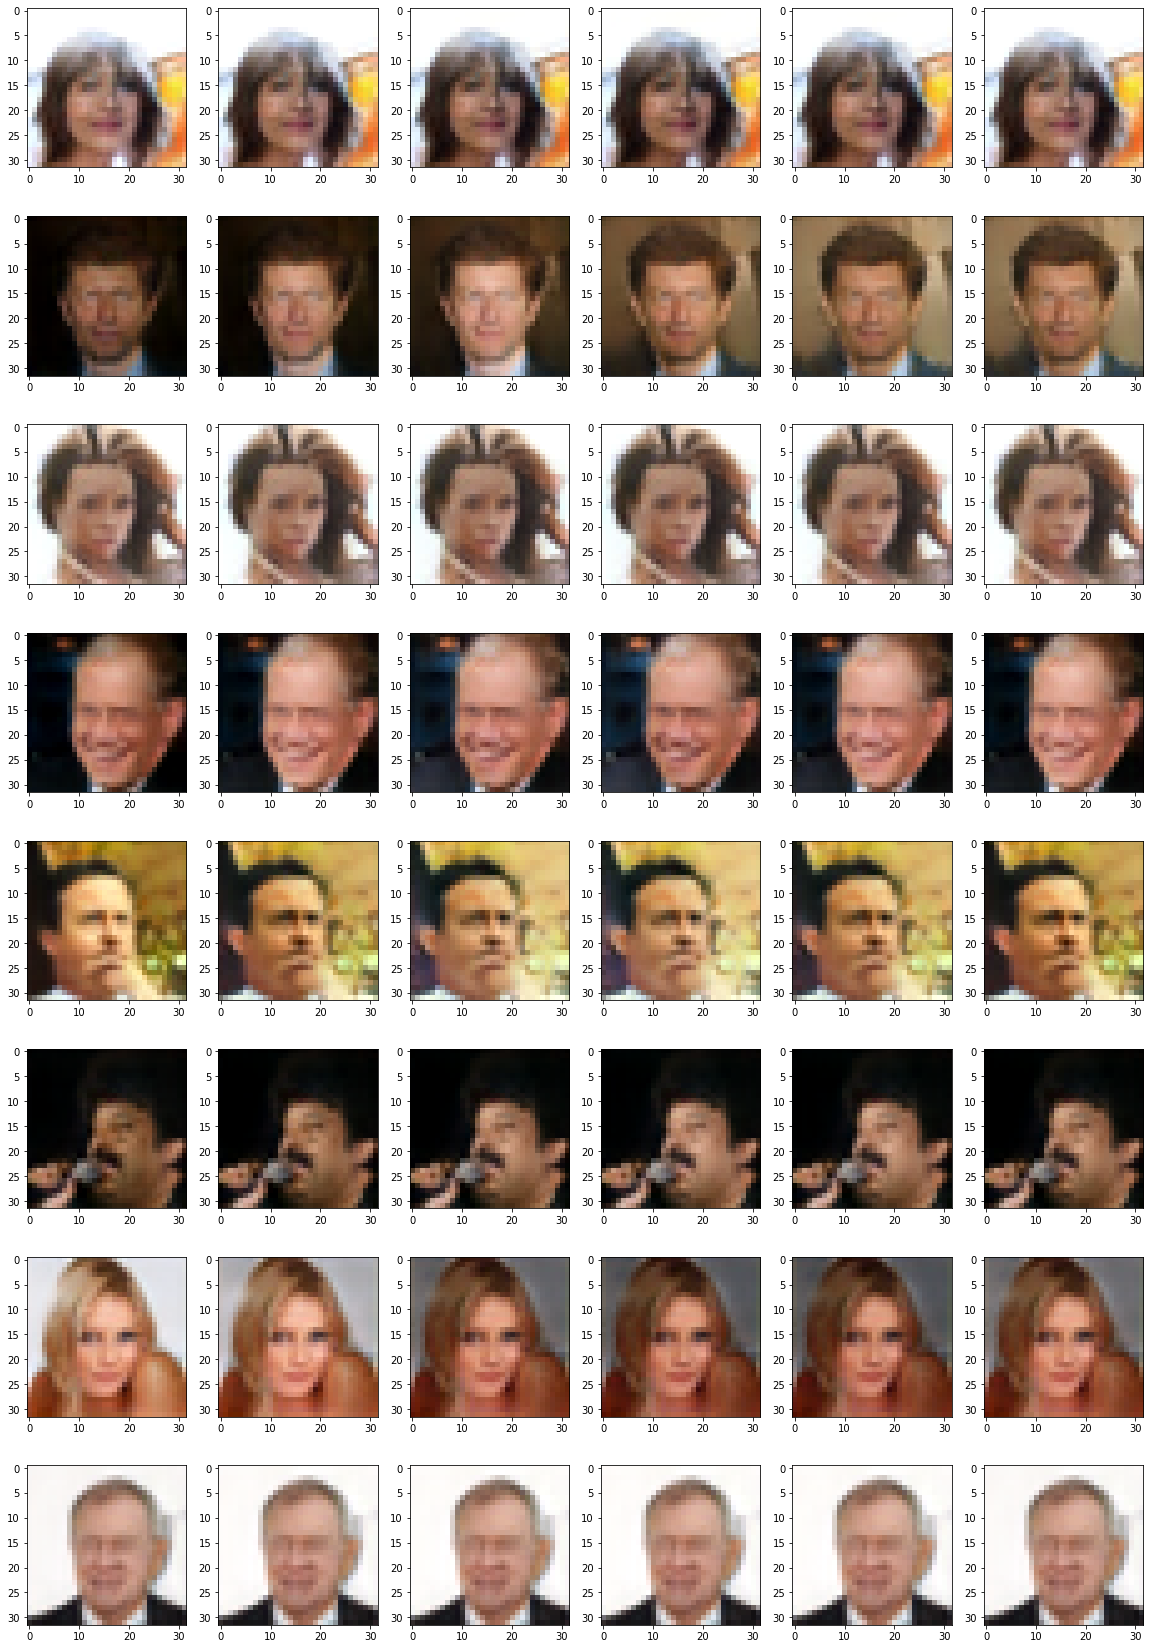

In [101]:
with torch.no_grad():
    z_trg1 = torch.randn((args.batch_size, 16)).to(device)
    z_trg2 = torch.randn((args.batch_size, 16)).to(device)


plt.figure(figsize=(20, 30))
for i in range(args.batch_size):
  for a in np.linspace(0, 1, 6):
    with torch.no_grad():
          y_real = ((target['attributes'][:, 20] + 1) / 2)
          s_trg = nets.mapping_network((a * z_trg1 + (1 - a) * z_trg2).to(device), [x.to(device).long() for x in [y_real, y_real]][0])
          x = nets_ema.generator(x_real, s_trg)[i]
    plt.subplot(args.batch_size, 6, i * 6 + int(a / 0.2) + 1);
    plt.imshow(denormalize_image(x).permute(1,2,0).detach().cpu().numpy());
plt.show();